# Benchmarking Google Translation of English to Chichewa
---
In this notebook, the goal is to investigate the accuracy of machine translation (MT) of English to Chinyanja. Note that I will often use Chichewa instead of Chinyanja but officially, this language is known as Chinyanja (ny). Out of all NLP capabilities this language, MT is probably the most well developed. However, my suscipion has always been that the quality (accuracy) of MT of English to Chichwa is way too low compared to other languages. As such, the experiments in this notebook will to provode first ever public benchmarks. 

The goal is very simple: to document benchmarks as to how accurate current MT systems-in this case **Google** for English to Chichewa translation. 

In [14]:
import warnings
warnings.filterwarnings('ignore')
import nltk
# nltk.download('all')
from google.cloud import translate_v2 as translate
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize, sent_tokenize
from googletrans import Translator, LANGUAGES
import pandas as pd
import numpy as np
from IPython.display import Image, display
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Define utility functions

In [130]:
def compute_bleu_score(df_sent: pd.DataFrame, chich_cols: list, en_col: str):
    """
    Computes BLUE score over all sentences in a Dataframe.
    df_sent: Dataframe with sentences in English translated to Chichewa
    chich_cols: Columns containing human translated Chichewa sentences
    en_col: Column containing original English sentence to be translated
    
    returns the following:
        - mean BLEU score over all sentences successfully translated and number of sentences
        - Total sentences where BLEU is run
        - Total number of characters 
    """
    scores = []
    sent_cnts = 0
    char_cnts = 0
    for idx, row in df_sent.iterrows():
        try:
            eng_sent = row[en_col]
            chich_google = translate_with_google_api(dest='ny', src='en', text=eng_sent)
            chich_google_tokens = [tok for tok in word_tokenize(chich_google) if tok.isalpha()]
            sent_cnts += 1
            char_cnts += len(sent_tokens)
        except Exception as e:
            print(e)
        
        try:
            human_chich_tokens = []
            for col in chich_cols:
                chich_tokens = word_tokenize(row[col])
                chich_tokens_clean = [token for token in chich_tokens if token.isalpha()]
                human_chich_tokens.append(chich_tokens_clean)
            score = sentence_bleu(references=human_chich_tokens, hypothesis=chich_google_tokens)
            scores.append(score)
        except Exception as e:
            print('BLEU CALCULATION FAILED ...')
            print(e)
            
    mean_score = np.mean(scores)
    
    return mean_score, sent_cnts, char_cnts

In [128]:
def translate_with_google_api(dest: str, src: str, text: str, use_paid=True) -> dict:
    """Translates text into the target language using Google using either 
    the paid Cloud Translation API or free Googletrans Python package. 

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    # Google commercial API
    translate_client = translate.Client()
    
    # Google free API through Python
    translator = Translator()
    
    if isinstance(text, bytes):
        text = text.decode("utf-8")
    
    if use_paid:
        # Text can also be a sequence of strings, in which case this method
        # will return a sequence of results for each text.
        result = translate_client.translate(text, target_language=dest,source_language=src)
        return result["translatedText"]
    else:
        result = translator.translate(text, dest='ny', src='en')
        return result.text

## BLEU score 
In this experiment, we use [BLEU (BiLingual Evaluation Understudy)](https://en.wikipedia.org/wiki/BLEU) score as the evaluation metric simply because its the most commonly used metric in MT. 
In summary, BLEU measures a candidate translation closeneness to references sentences (ground truth) which can be one or more. A BLEU score ranges from 0 to 1 and it can be interepreted as a percentage for easier interpretation.

For context, this is how Google relates BLEU score with MT system reliability.

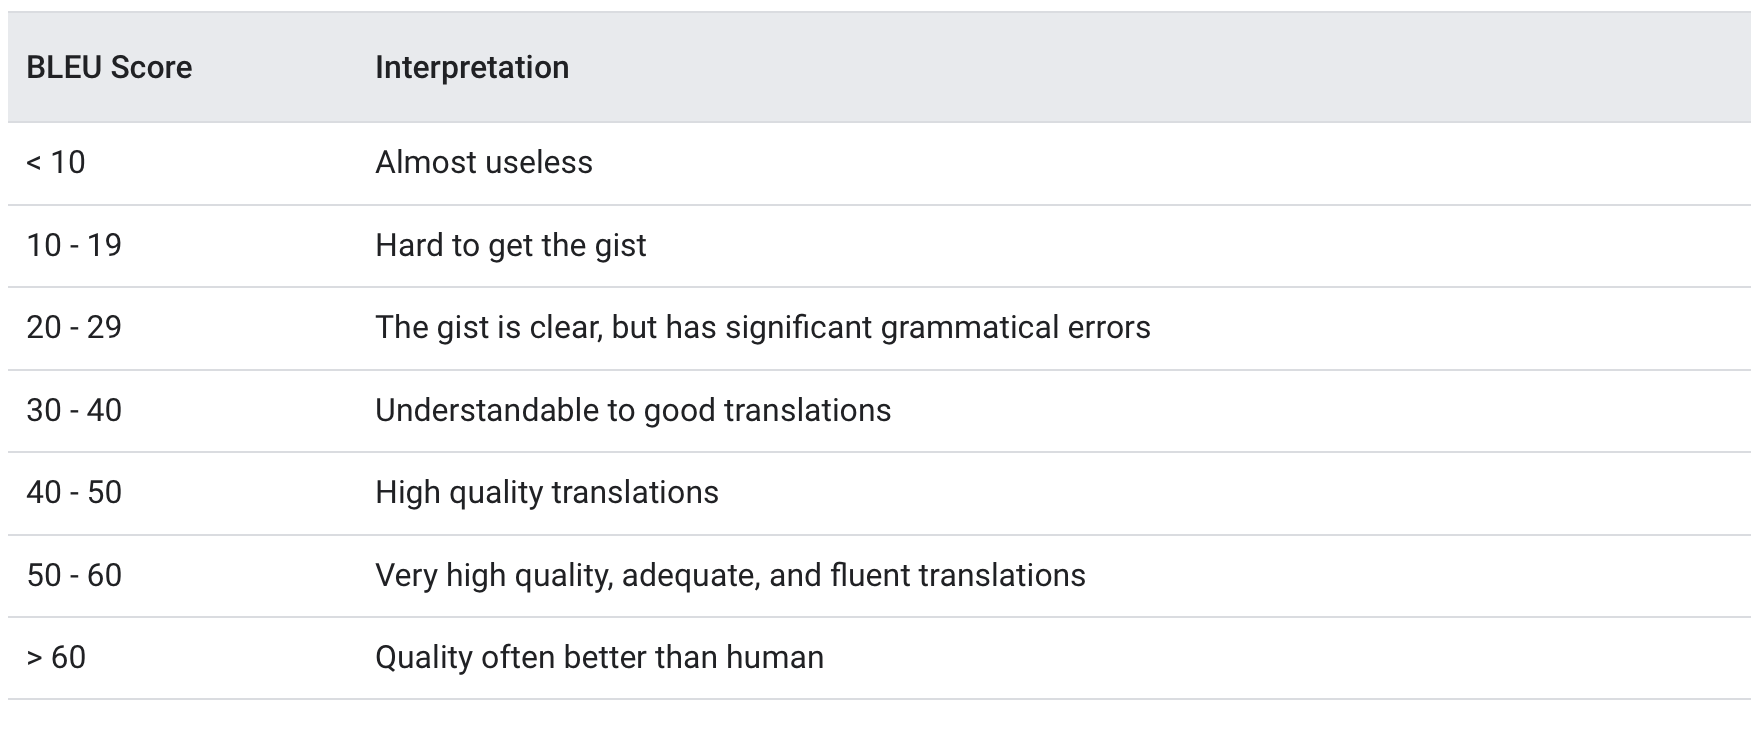

In [4]:
display(Image(filename='../docs/images/BLEU-score-interpreration.png'))

## Datasets for evaluation
In this experiment, we use three independent datasets as follows.

### Dataset-1: Translations based on online sources
In this dataset, two non-professional native speakers of Chichewa performed the translation frmon English to Chichewa. The source English sentences came from several places online: Malawi news articles, WhatsApp posts and other online translation datasets.

In [93]:
df_online = pd.read_csv("../data/chich2english-translation/english2chich-online-texts.csv")
df_online1 = df_online[['sentence', 'chich_shadreck']].dropna()
df_online2 = df_online[['sentence', 'chich_gloria']].dropna()
df_online12 =  df_online[['sentence', 'chich_gloria', 'chich_shadreck']].dropna()

In [6]:
print('='*40)
print(' Summary Stats for Dataset-1')
print('='*40)
print('1. Number of English sentences: 686')
print('2. Translator-1: {}'.format(len(df_online)))
print('3. Translator-2: {}'.format(len(df_online2)))
print('4. Translator-1 and 2: {}'.format(len(df_online12)))
print('-'*40)

 Summary Stats for Dataset-1
1. Number of English sentences: 686
2. Translator-1: 686
3. Translator-2: 275
4. Translator-1 and 2: 245
----------------------------------------


### Dataset-2: Profensional translation of a political speech
A colleague, Cresencia Masautso donated this dataset to me. 
Its based on the translation she did of one of the political figure in Malawi who made 
the speech in English and she translated it to Chichewa. 

The dataset was created by chunking the documents into short paragraphs in ordet to have matching 
English and Chichewa texts.As such, there is only translation from one person who can be considered as a professional translator.

In [7]:
df_prof = pd.read_csv("../data/chich2english-translation/english2chich-prof-translator.csv")

In [ ]:
sentences = []

for idx, row in df_prof.iterrows():
    sent = sent_tokenize(row['english'])
    sentences += sent

In [9]:
print('='*40)
print(' Summary Stats for Dataset-2')
print('='*40)
print(' 1. Number of English sentences: {}'.format(len(sentences)))
print('-'*40)

 Summary Stats for Dataset-2
 1. Number of English sentences: 259
----------------------------------------


### Dataset-3: Translation for a health related public project
A colleague, Lumbani Pete donated this dataset to me. 
Its based on the translation which was done for content which is on [this website](https://streetscience.info)
about the work on awareness about sleeping sickness caused by Tsetse flies.

In [10]:
df_wb = pd.read_csv("../data/chich2english-translation/chich2english-website-sourced.csv")

In [11]:
sentences = []

for idx, row in df_wb.iterrows():
    sent = sent_tokenize(row['english'])
    sentences += sent

In [12]:
print('='*40)
print(' Summary Stats for Dataset-3')
print('='*40)
print(' 1. Number of English sentences: {}'.format(len(sentences)))
print('-'*40)

 Summary Stats for Dataset-3
 1. Number of English sentences: 115
----------------------------------------


## Evaluation setup

### BLEU score computation
For each dataset, we will compute a sentence level BLEU score and 
then average over all sentences in the dataset. For dataset-1 with 2 translators, we will generate three scores: one for each translator and one based on 2 reference translations from two translators. We use ```sentence_bleu``` function from the NLTK package to calculate sentence level BLEU. 

### Google translation API
The Python package googletrans which is used here makes calls to [Google translate Ajax API] (https://translate.google.com/) and so we can assume its using the same model used on regular Google translation on the web and mobile. 

## Calculate BLEU score for datasets

### BLEU score for dataset-1: Two translators

In [131]:
score, sent_count, character_cnt = compute_bleu_score(df_sent=df_online12, en_col='sentence', 
                                                      chich_cols=['chich_shadreck', 'chich_gloria'])

In [132]:
print("="*65)
print(' AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-1 AND TRANSLATOR-2')
print("="*65)
print('1. Average score: {:.2f}%'.format(np.mean(score)*100))
print('2. Number of sentences translated: {:,}'.format(sent_count))
print('3. Number of characters translated: {:,}'.format(character_cnt))

 AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-1 AND TRANSLATOR-2
1. Average score: 8.63%
2. Number of sentences translated: 245
3. Number of characters translated: 6,370


### BLEU score for dataset-1: Translator-1

In [134]:
score, sent_count, character_cnt = compute_bleu_score(df_sent=df_online1, en_col='sentence', 
                                                      chich_cols=['chich_shadreck'])

In [96]:
print("="*65)
print(' AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-1')
print("="*65)
print('1. Average score: {:.2f}%'.format(np.mean(score)*100))
print('2. Number of sentences translated: {:,}'.format(sent_count))
print('3. Number of characters translated: {:,}'.format(character_cnt))

 AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-1 AND TRANSLATOR-2
1. Average score: 4.99%
2. Number of sentences translated: 645
3. Number of characters translated: 16,770


### BLEU score for dataset-1: Translator-2

In [ ]:
score, sent_count, character_cnt = compute_bleu_score(df_sent=df_online2, en_col='sentence', 
                                                      chich_cols=['chich_gloria'])

In [135]:
print("="*65)
print(' AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-2')
print("="*65)
print('1. Average score: {:.2f}%'.format(np.mean(score)*100))
print('2. Number of sentences translated: {:,}'.format(sent_count))
print('3. Number of characters translated: {:,}'.format(character_cnt))

 AVERAGE BLEU SCORE FOR DATASET-1, TRANSLATOR-2
1. Average score: 4.96%
2. Number of sentences translated: 645
3. Number of characters translated: 16,770


### BLEU score for dataset-2

In [137]:
score, sent_count, character_cnt = compute_bleu_score(df_sent=df_prof, en_col='english', 
                                                      chich_cols=['chichewa'])

In [139]:
print("="*65)
print(' AVERAGE BLEU SCORE FOR DATASET-2')
print("="*65)
print('1. Average score: {:.2f}%'.format(score*100))
print('2. Number of sentences translated: {:,}'.format(sent_count))
print('3. Number of characters translated: {:,}'.format(character_cnt))

 AVERAGE BLEU SCORE FOR DATASET-2
1. Average score: 15.74%
2. Number of sentences translated: 61
3. Number of characters translated: 1,586


### BLEU score for dataset-3

In [142]:
score, sent_count, character_cnt = compute_bleu_score(df_sent=df_wb, en_col='english', 
                                                      chich_cols=['chichewa'])

In [143]:
print("="*65)
print(' AVERAGE BLEU SCORE FOR DATASET-2')
print("="*65)
print('1. Average score: {:.2f}%'.format(score*100))
print('2. Number of sentences translated: {:,}'.format(sent_count))
print('3. Number of characters translated: {:,}'.format(character_cnt))

 AVERAGE BLEU SCORE FOR DATASET-2
1. Average score: 3.64%
2. Number of sentences translated: 102
3. Number of characters translated: 2,652


### BLEU score for English to Spanish translation

In [166]:
df = pd.read_csv("/Users/dunstanmatekenya/Downloads/spa-eng/spa.txt", sep="\t", header=None, names=['en', 'sp'])
keep = []
for idx, row in df.iterrows():
    sent = row['en']
    tokens = word_tokenize(sent)
    if len(sent) > 90:
        keep.append(idx)

In [167]:
tmp = df.loc[keep]

In [169]:
tmp

,en,sp
118632,A study found that almost 10% of men were obes...,Un estudio descubrió que casi un 10% de los ho...
118633,"Do you swear to tell the truth, the whole trut...","¿Juras decir la verdad, toda la verdad y nada ..."
118635,Good friends are like stars. You don't always ...,Los buenos amigos son como las estrellas: no s...
118636,If you concentrate all your energies on the st...,Si concentras todas tus energías en el estudio...
118637,"In January of that year, we saw snow for four ...","En enero de ese año, vimos nevar durante cuatr..."
...,...,...
118959,There are four main causes of alcohol-related ...,Hay cuatro causas principales de muertes relac...
118960,There are mothers and fathers who will lie awa...,Hay madres y padres que se quedan despiertos d...
118961,A carbon footprint is the amount of carbon dio...,Una huella de carbono es la cantidad de contam...
118962,Since there are usually multiple websites on a...,Como suele haber varias páginas web sobre cual...


In [150]:
pd.read_csv?

Signature:
pd.read_csv(
    filepath_or_buffer: 'FilePath | ReadCsvBuffer[bytes] | ReadCsvBuffer[str]',
    *,
    sep: 'str | None | lib.NoDefault' = <no_default>,
    delimiter: 'str | None | lib.NoDefault' = None,
    header: "int | Sequence[int] | None | Literal['infer']" = 'infer',
    names: 'Sequence[Hashable] | None | lib.NoDefault' = <no_default>,
    index_col: 'IndexLabel | Literal[False] | None' = None,
    usecols=None,
    squeeze: 'bool | None' = None,
    prefix: 'str | lib.NoDefault' = <no_default>,
    mangle_dupe_cols: 'bool' = True,
    dtype: 'DtypeArg | None' = None,
    engine: 'CSVEngine | None' = None,
    converters=None,
    true_values=None,
    false_values=None,
    skipinitialspace: 'bool' = False,
    skiprows=None,
    skipfooter: 'int' = 0,
    nrows: 'int | None' = None,
    na_values=None,
    keep_default_na: 'bool' = True,
    na_filter: 'bool' = True,
    verbose: 'bool' = False,
    skip_blank_lines: 'bool' = True,
    parse_dates=None,
    infer

## Formal speech

In [ ]:
df_sent = pd.read_csv("/Users/dunstanmatekenya/Downloads/english2chich-prof-translator.csv")

In [ ]:
scores = []
for idx, row in df_sent.iterrows():
    try:
        sent = row['english']
        sent_tokens = word_tokenize(sent)
        hypothesis = translator.translate(row['english'], dest='ny').text
        hypothesis_tokens = word_tokenize(hypothesis)
        ref_tokens = word_tokenize(row['chichewa'])
        score = sentence_bleu([ref_tokens], hypothesis_tokens)
        scores.append(score)
    except:
        pass

In [ ]:
np.mean(scores)

In [33]:
df_online12

,sentence,chich_gloria,chich_shadreck
12,"She said: “To achieve that, we are promoting d...",Iye adati kuti tikwaniritse zimenezi tikulimbi...,"Iwo anati: ""Kuti tikwanitse zimenezi, tikulimb..."
25,"Speak up, contribute here!","Yankhulani, pelekani maganizo anu pano!","Lankhulani, perekani maganizo anu pano!"
27,"If you know someone with heart problems, pleas...",Ngati mukudziwa winawake ali ndi vuto la ntima...,Ngati mukudziwa wina aliyense yemwe ali ndi v...
28,Good morning friends. Queen Elizabeth Central ...,Mwadzuka bwanji Anzanga. QECH ikhala ikulandil...,"Moni azizanga, Quees central hospital chikhal..."
29,People will judge me and say what they want to...,Anthu adzandiweruza ndiposo adzanena zomwe aku...,Anthu andiweruza ndikundinena mmene anganenere...
...,...,...,...
321,There were three hundred cardboard boxes fille...,Panali ma bokosi zikwi zitatu odzadza ndi zova...,Panali makatoni okwana 3 handilede odzadza n...
322,Tom felt the stiffness in his joints as he sto...,Thomu anava kulimba polumikizila mafupa pomwe ...,Tom anaverera dzadzi mu sagwada zake pomwe ama...
323,Tom prefers to take a shower in the morning wh...,Thomu amakonda kusamba mmawa pamene Mele amako...,Tom amakonda kusamba m'mamawa pomwe Mary amafu...
324,"Tom sprang out of bed, threw on some clothes, ...","Thomu anadupha mwachangu kuchoka pa kama, n’ku...","Tom anadzumbutuka pakama pake, kuvala zovala..."
